In [5]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde 
from analytical import sound_hard_circle


#dde.config.set_default_float('float64')
#dde.config.set_default_float('float64')
dde.config.set_default_float('float32')


'''                        Problem parameters                               '''
k0 = 1           # wavenumber
# 5 is fine!
# 8 is more or less ok. ¿Add more points?
# Added more points, but not really ok with just 20.000 iterations + BFGS
# Change the learning rate? 
# Avec8 et 15 points, learning rate = 0.05, n'arrive pas a apprendre l'interieur...

wave_len = np.pi / k0  # wavelength

dim_x = 2 * np.pi

R = np.pi / 2.
n_wave = 10

# The mesh element size is h_elem
h_elem = wave_len / n_wave

nx = int(dim_x / h_elem)
print(h_elem, 'h_elem')
print( nx, 'nx')
print(nx **2, 'nx**2')

Set the default float type to float32
0.3141592653589793 h_elem
20 nx
400 nx**2


Compiling model...
Building feed-forward neural network...
'build' took 0.041893 s



/opt/conda/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/opt/conda/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-10-29 07:45:21.482560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-10-29 07:45:21.482608: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      


'compile' took 0.746670 s

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric   
0         [1.60e-01, 1.63e-02, 4.40e-01, 4.52e-02, 2.11e-01, 1.79e+00]    [1.68e-01, 1.69e-02, 4.40e-01, 4.52e-02, 2.11e-01, 1.79e+00]    [1.05e+00]    
1000      [5.67e-02, 9.29e-03, 7.03e-03, 3.22e-03, 9.50e-03, 1.64e-02]    [4.47e-02, 9.80e-03, 7.03e-03, 3.22e-03, 9.50e-03, 1.64e-02]    [1.64e-01]    
2000      [6.19e-03, 1.23e-03, 1.55e-04, 2.46e-04, 7.94e-04, 6.30e-04]    [3.70e-03, 1.08e-03, 1.55e-04, 2.46e-04, 7.94e-04, 6.30e-04]    [3.85e-02]    
3000      [8.97e-04, 2.23e-04, 3.31e-05, 2.93e-05, 1.72e-04, 1.29e-04]    [7.15e-04, 2.23e-04, 3.31e-05, 2.93e-05, 1.72e-04, 1.29e-04]    [1.87e-02]    
4000      [2.44e-04, 1.12e-04, 6.58e-06, 5.77e-06, 4.35e-05, 4.70e-05]    [1.92e-04, 1.20e-04, 6.58e-06, 5.77e-06, 4.35e-05, 4.70e-05]    [1.07e-02]    
5000      

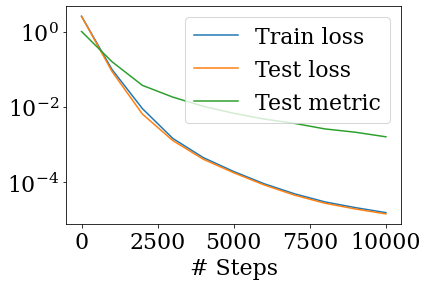

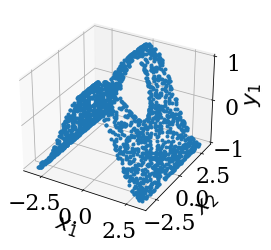

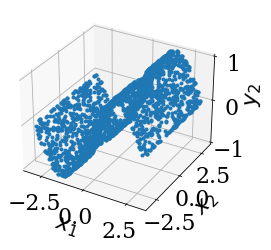

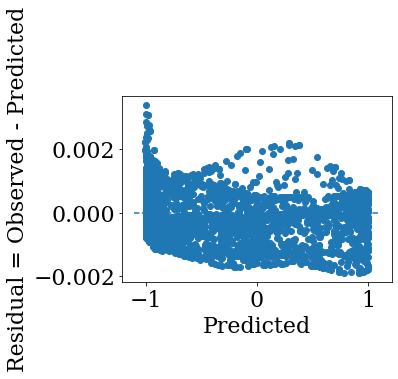

In [6]:
#geom = dde.geometry.Rectangle([-dim_x/2., -dim_x/2.], [dim_x/2., dim_x/2.])

outer = dde.geometry.Rectangle([-dim_x/2., -dim_x/2.], [dim_x/2., dim_x/2.])
inner = dde.geometry.Disk([0,0], R)

geom = dde.geometry.CSGDifference(outer, inner)

def pde(x, y):
    y0, y1 = y[:, 0:1], y[:, 1:2]
    
    y0_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    y0_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    y1_xx = dde.grad.hessian(y, x,component=1, i=0, j=0)
    y1_yy = dde.grad.hessian(y, x,component=1, i=1, j=1)

    return [-y0_xx - y0_yy - k0 ** 2 * y0,
            -y1_xx - y1_yy - k0 ** 2 * y1]

def sol(x):
    return np.exp(1j * k0 * x[:, 0:1])

def boundary(_, on_boundary):
    return on_boundary

def boundary_outer(_, on_boundary):
    return on_boundary and outer.on_boundary(_)

def boundary_inner(_, on_boundary):
    return on_boundary and inner.on_boundary(_)

def func0_inner(x):
    #result = np.exp(1j * k0 * x[:, 0:1])
    normal = -inner.boundary_normal(x)
    g = 1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * normal[:, 0:1]
    return np.real(g)

def func1_inner(x):
    #result = np.exp(1j * k0 * x[:, 0:1])
    normal = -inner.boundary_normal(x)
    g = 1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * normal[:, 0:1]
    return np.imag(g)

def func0_outer(x, y):
    normal = outer.boundary_normal(x)
    g = 1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * (normal[:, 0:1] - 1)
    result = np.real(g) - k0 * y[:, 1:2]
    return result

def func1_outer(x, y):
    normal = outer.boundary_normal(x)
    g = 1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * (normal[:, 0:1] - 1)
    result = np.imag(g) + k0 * y[:, 0:1]
    return result


    
bc0_inner = dde.NeumannBC(geom, func0_inner, boundary_inner, component = 0)
bc1_inner = dde.NeumannBC(geom, func1_inner, boundary_inner, component = 1)

bc0_outer = dde.RobinBC(geom, func0_outer, boundary_outer, component = 0)
bc1_outer = dde.RobinBC(geom, func1_outer, boundary_outer, component = 1)


def func(x):
    real = np.cos(k0 * x[:, 0:1])
    imag = np.sin(k0 * x[:, 0:1])
    return np.hstack((real, imag))

bcs = [bc0_inner, bc1_inner, bc0_outer, bc1_outer]
#weights = [1, 1, 100, 100, 100, 100]
weights = [1, 1, 1, 1, 1, 1]


data = dde.data.PDE(geom, pde, bcs, num_domain= nx**2, num_boundary= 8 * nx, num_test= 5 * nx ** 2, solution = func)
net = dde.maps.FNN([2] + [50] * 4 + [2], "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=0.0001, loss_weights= weights, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

#model.compile("L-BFGS")
#losshistory, train_state = model.train()

Relative error =  0.001668820793539344


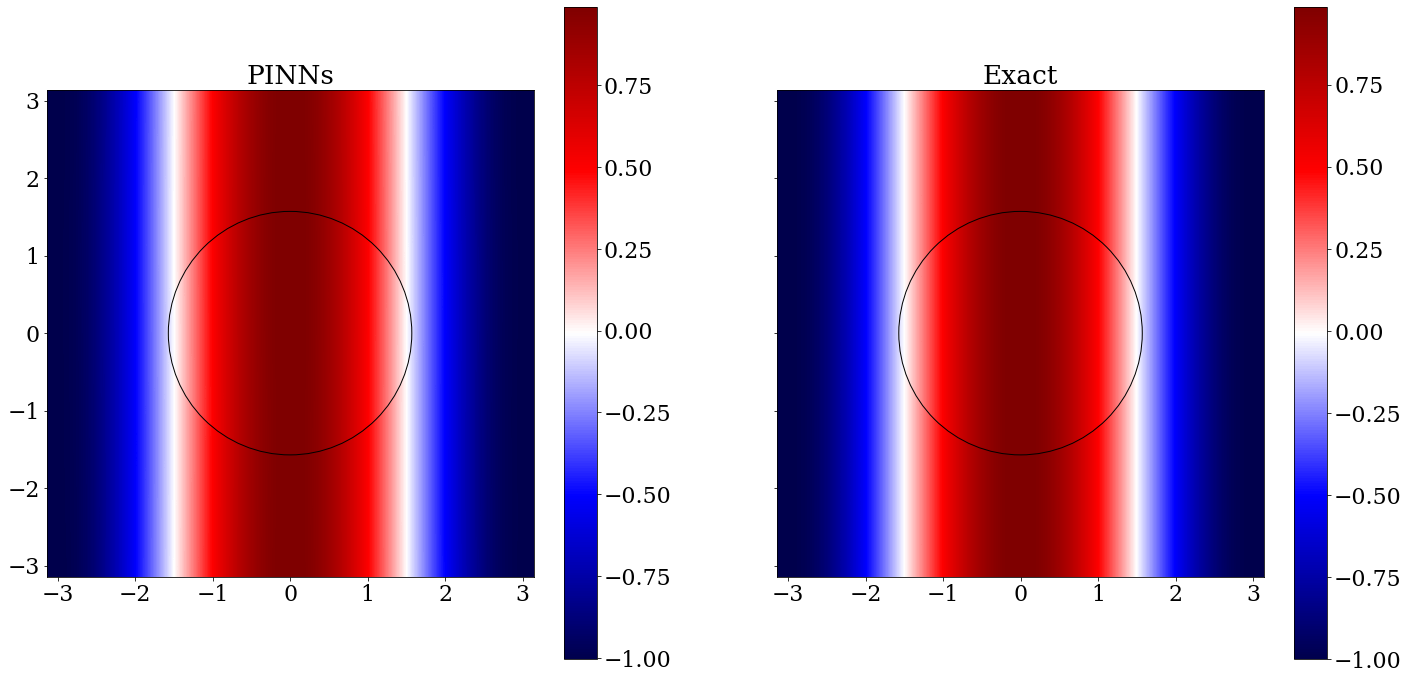

In [7]:

'''            Evaluate field over a specified grid of points              '''
# Square grid with 10 points per wavelength in each direction
Nx = int(np.ceil(dim_x/wave_len * 10))
Ny = Nx


# Grid points
xmin, xmax, ymin, ymax = [-dim_x/2, dim_x/2., -dim_x/2, dim_x/2]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

points_2d = points[:2, :]

#in_circ = points[0, :]**2 + points[1, :]**2 <= (radius)**2
#in_circ_2d = points_2d[0, :]**2 + points_2d[1, :]**2 <= (radius)**2
#points[0, in_circ] = -radius - wave_len / 10
#points[1, in_circ] = radius + wave_len / 10
#points[2, in_circ] = 0.

# Bounding box tree etc for function evaluations

u_sca = model.predict(points[:2, :].T)
u_sca = u_sca[:, 0] + 1j* u_sca[:, 1]
u_sca = u_sca.reshape((Nx, Ny))

'''                  Compare against analytical solution                    '''
# Uncomment to perform comparison, takes a few seconds to run

u_exact = sol(points.T)
u_exact = u_exact.reshape((Nx, Ny))
diff = u_exact-u_sca
error = np.linalg.norm(diff)/np.linalg.norm(u_exact)
print('Relative error = ', error)

'''                     Plot field and save figure                          '''
plt.rc('font', family='serif', size=22)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (24,12))

pcm = ax1.imshow(np.fliplr(np.real(u_sca)).T,
           extent=[-dim_x/2, dim_x/2., -dim_x/2, dim_x/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='PINN')

circle = plt.Circle((0., 0.), R, color='black', fill=False)
ax1.add_patch(circle)
#ax1.axis('off')
fig.colorbar(pcm, ax = ax1)

pcm = ax2.imshow(np.fliplr(np.real(u_exact)).T,
           extent=[-dim_x/2, dim_x/2., -dim_x/2, dim_x/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label = 'Exact')

circle = plt.Circle((0., 0.), R, color='black', fill=False)
ax2.add_patch(circle)

#ax1.axis('off')
ax1.set_title('PINNs')
ax2.set_title('Exact')
fig.colorbar(pcm, ax = ax2)


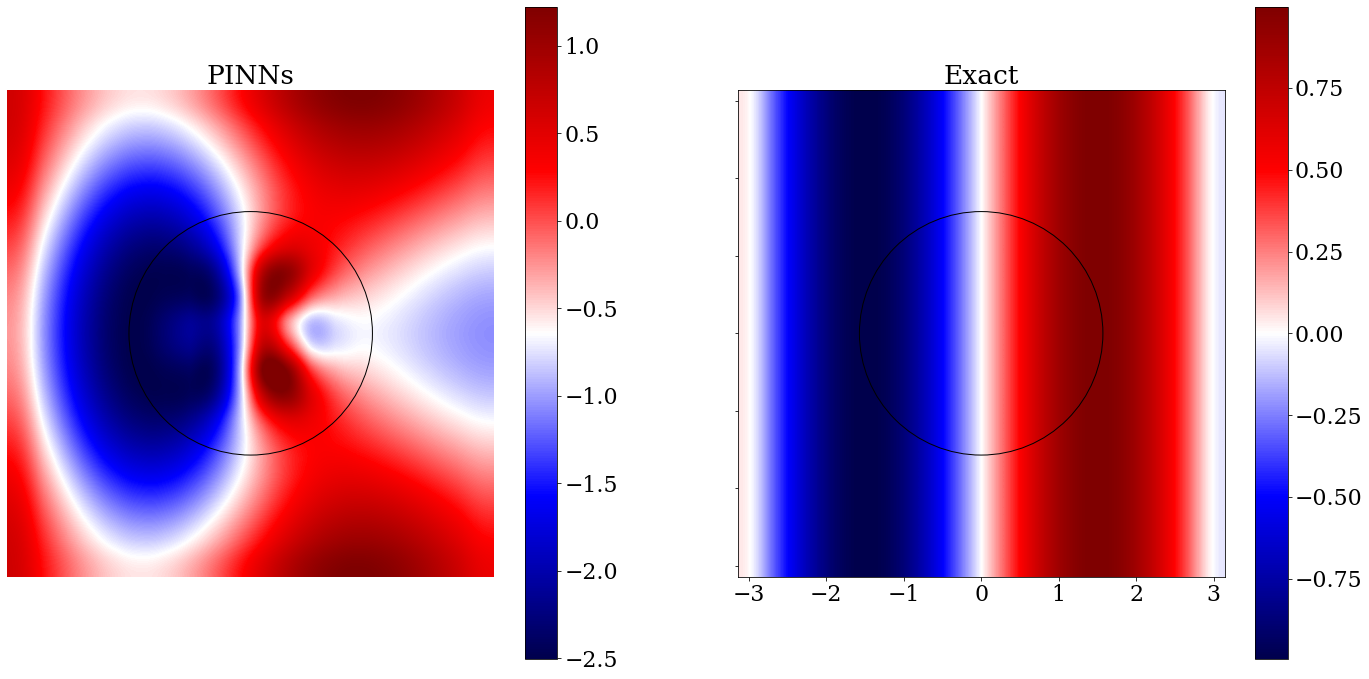

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (24,12))

pcm = ax1.imshow(np.fliplr(np.imag(u_sca)).T,
           extent=[-dim_x/2,dim_x/2.,-dim_x/2,dim_x/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='PINN')


ax1.axis('off')
circle = plt.Circle((0., 0.), R, color='black', fill=False)
ax1.add_patch(circle)
fig.colorbar(pcm, ax = ax1)

pcm = ax2.imshow(np.fliplr(np.imag(u_exact)).T,
           extent = [-dim_x/2,dim_x/2.,-dim_x/2,dim_x/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label = 'Exact')

circle = plt.Circle((0., 0.), R, color='black', fill=False)
ax2.add_patch(circle)


#ax1.axis('off')
ax1.set_title('PINNs')
ax2.set_title('Exact')
fig.colorbar(pcm, ax = ax2)
